<a href="https://colab.research.google.com/github/wassimdami/Deep_Learning_with_PyTorch_Image_Segmentation/blob/main/Deep_Learning_with_PyTorch_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-9q9_67yq
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-9q9_67yq
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


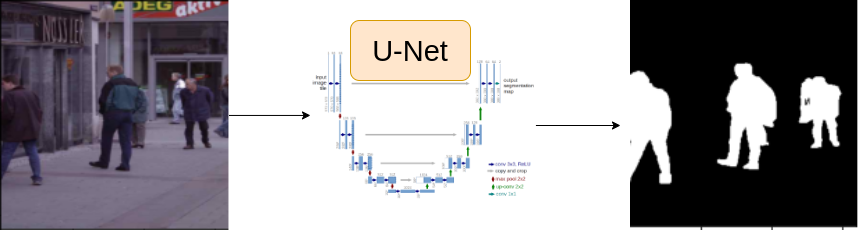

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS =25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE =16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)

In [ ]:
row = df.iloc[1]

image_path = row.images
mask_path =row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

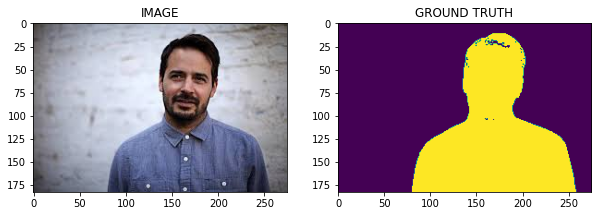

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2 , random_state =42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs() : 
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
       ])

def get_valid_augs ():
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        ])  

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

      self.df = df
      self.augmentations = augmentations

  def __len__(self):
      return len(self.df)


  def __getitem__(self, idx):

      row = self.df.iloc[idx]

      image_path = row.images
      mask_path = row.masks

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, W, c)
      mask = np.expand_dims(mask, axis =-1)

      if self.augmentations:
          data = self.augmentations(image = image, mask = mask)
          image = data['image']
          mask = data['mask']
 
 
      #(h,w,c) -> (c,h,w)

      image =np.transpose(image,(2,0,1)).astype(np.float32)
      mask =np.transpose(mask,(2,0,1)).astype(np.float32)
      image = torch.Tensor(image) / 255.0 
      mask = torch.round(torch.Tensor(mask) / 255.0)
      return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


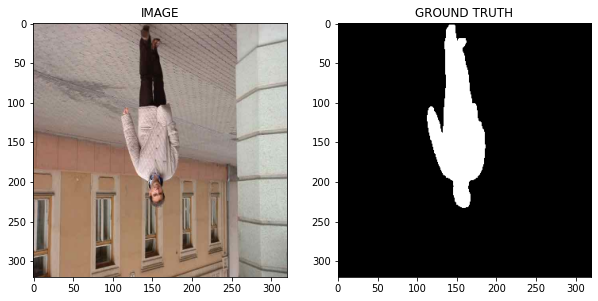

In [ ]:
idx = 14
image, mask = trainset[idx]
helper.show_image(image, mask)


# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels =3,
        classes =1,
        activation = None
    )
  def forward(self, images, masks = None):
      logits = self.arc(images)   

      if masks != None:
        loss1 = DiceLoss (mode='binary') (logits, masks)
        loss2 = nn.BCEWithLogitsLoss() (logits, masks)
        return logits, loss1 + loss2
      return logits  

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader, model, optimizer):
    
    model.train()
    total_loss = 0.0
    
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      optimizer.zero_grad() 
      logits, loss = model (images, masks)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
    return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
    
    model.eval()
    total_loss =0.0
    with torch.no_grad():
      for images, masks in tqdm(data_loader):

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        logits, loss = model(images, masks)
        total_loss += loss.item()
    return total_loss / len(data_loader) 

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:
      torch.save(model.state_dict(), 'best_model.pt')
      print("SAVED-MODEL")
      best_valid_loss = valid_loss

    print(f"Epoch : {i+1} Train_loss :{train_loss} Valid_loss :{valid_loss}" )

100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


SAVED-MODEL
Epoch : 1 Train_loss :0.7693345626195272 Valid_loss :1.2761335372924805


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


SAVED-MODEL
Epoch : 2 Train_loss :0.4075292984644572 Valid_loss :0.5167983621358871


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


SAVED-MODEL
Epoch : 3 Train_loss :0.3032608091831207 Valid_loss :0.2700805589556694


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch : 4 Train_loss :0.30931158661842345 Valid_loss :0.28438056260347366


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


SAVED-MODEL
Epoch : 5 Train_loss :0.22987228135267893 Valid_loss :0.2376827821135521


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


SAVED-MODEL
Epoch : 6 Train_loss :0.24249444504578907 Valid_loss :0.22909748554229736


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


SAVED-MODEL
Epoch : 7 Train_loss :0.27770134111245476 Valid_loss :0.21901599690318108


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch : 8 Train_loss :0.2576913634936015 Valid_loss :0.22259818762540817


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


SAVED-MODEL
Epoch : 9 Train_loss :0.17401910722255706 Valid_loss :0.21475955098867416


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch : 10 Train_loss :0.16533424705266953 Valid_loss :0.24982593208551407


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


SAVED-MODEL
Epoch : 11 Train_loss :0.16078670024871827 Valid_loss :0.1944950893521309


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch : 12 Train_loss :0.14597144822279612 Valid_loss :0.2038749847561121


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED-MODEL
Epoch : 13 Train_loss :0.16835453013579052 Valid_loss :0.1915704943239689


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 14 Train_loss :0.13000959853331248 Valid_loss :0.2076408863067627


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


SAVED-MODEL
Epoch : 15 Train_loss :0.1436031550168991 Valid_loss :0.16432653740048409


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 16 Train_loss :0.1190429409344991 Valid_loss :0.17985744774341583


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch : 17 Train_loss :0.12972632199525833 Valid_loss :0.22415473498404026


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch : 18 Train_loss :0.15032099137703578 Valid_loss :0.2107577957212925


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 19 Train_loss :0.13328088869651158 Valid_loss :0.20904092863202095


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


SAVED-MODEL
Epoch : 20 Train_loss :0.12757864048083623 Valid_loss :0.15250099822878838


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


Epoch : 21 Train_loss :0.12496135830879211 Valid_loss :0.22319353371858597


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch : 22 Train_loss :0.11380585283041 Valid_loss :0.19957110285758972


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch : 23 Train_loss :0.12504633764425913 Valid_loss :0.2125209979712963


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch : 24 Train_loss :0.12222048540910085 Valid_loss :0.2202022410929203


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

Epoch : 25 Train_loss :0.11639029085636139 Valid_loss :0.1832282841205597


# Task 9 : Inference

In [ ]:
idx=11
model. load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))  #(c,h,w) ->(1,c,h,w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask >0.5) * 1.0

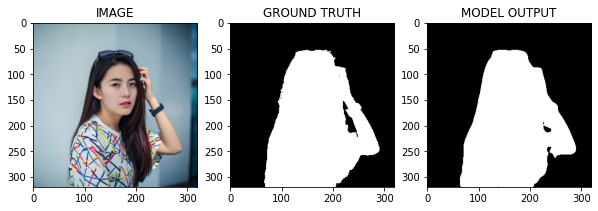

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))